# Thông tin nhóm
- 19127647 - Nguyễn Phú Quí
- 19127144 - Nguyễn Thành Hiệu
- 19127592 - Lê Minh Trí

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer,Normalizer

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,KFold,cross_val_score,StratifiedKFold
import statsmodels.formula.api as smf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from mlxtend.plotting import plot_learning_curves

from sklearn.linear_model import LinearRegression
import plotly.express as px

Đặt file Complete_dataset.csv ở ngoài folder chứa file code để chương trình có thể bắt được đường dẫn.

In [2]:
# Get local path of data
path = os.path.abspath(os.getcwd())
path = os.path.abspath(os.path.join(path, os.pardir)) + '\\Complete_dataset.csv'
path

'c:\\Users\\HP\\Desktop\\Data Analyst\\Projects\\Complete_dataset.csv'

In [3]:
df = pd.read_csv(path)
df = df.drop("Unnamed: 0",axis=1)

C:\Users\HP\AppData\Local\Temp\ipykernel_4212\4089235158.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [4]:
df2 = df.copy()

In [5]:
nan_list = df2.isna().sum().to_numpy()
nan_idx = []
for i in range(len(nan_list)):
  if nan_list[i] > 0:
    tmp = []
    tmp.append(df2.keys()[i])
    tmp.append(df2[df2.keys()[i]].dtypes)
    tmp.append(nan_list[i])
    tmp.append(round(nan_list[i]/df2.shape[0] *100,2))
    nan_idx.append(tmp)
df3 = pd.DataFrame(nan_idx, columns = ["col_name","type","nan_amount","%"])
df3

,col_name,type,nan_amount,%
0,latitude,float64,1,0.00
1,longitude,float64,1,0.00
2,name,object,418,0.08
3,host_name,object,504,0.10
4,host_response_time,object,115069,23.25
5,host_response_rate,float64,115070,23.25
6,city,object,454,0.09
7,country,object,3,0.00
8,property_type,object,11,0.00
9,room_type,object,1,0.00


## Data Preprosessing

Dựa vào df3, ta có thể thấy các cột như accommodates, bathrooms, bedrooms,... có số lượng nan khá ít nên ta có thể cân nhắc bỏ các dòng có chứa nan ở các cột này.

In [6]:
df2 = df2.dropna(subset=["accommodates", "bathrooms", "bedrooms", "beds", "extra_people","property_type"])

Ngoài ra, khi xóa các dòng này "vô tình" khiến một lượng lớn nan ở các cột khác cũng biến mất.

In [7]:
nan_list = df2.isna().sum().to_numpy()
nan_idx = []
for i in range(len(nan_list)):
  if nan_list[i] > 0:
    tmp = []
    tmp.append(df2.keys()[i])
    tmp.append(df2[df2.keys()[i]].dtypes)
    tmp.append(nan_list[i])
    tmp.append(round(nan_list[i]/df2.shape[0] *100,2))
    nan_idx.append(tmp)
df3 = pd.DataFrame(nan_idx, columns = ["col_name","type","nan_amount","%"])
df3

,col_name,type,nan_amount,%
0,name,object,413,0.08
1,host_name,object,499,0.10
2,host_response_time,object,114351,23.22
3,host_response_rate,float64,114351,23.22
4,city,object,450,0.09
5,country,object,2,0.00
6,price,float64,7915,1.61
7,reviews_per_month,float64,121207,24.61
8,review_scores_value,float64,128244,26.04
9,review_scores_cleanliness,float64,127641,25.92


### Ouliers Detection

Đối với việc phát hiện các outliers, ta tập trung vào cột target(price) để tìm ra chúng.

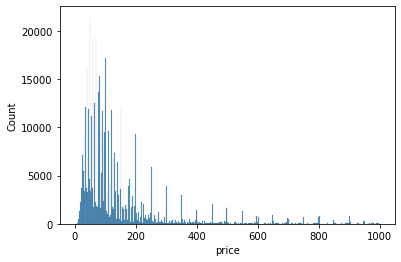

In [8]:
sns.histplot(data=df2, x="price")
plt.show()

Ta có thể thấy dữ liệu chủ yếu bị skew về bên phải vì một lượng lớn ảnh hưởng của outliers. Ví dụ có các nhà có giá cận 1000.

Khi quan sát tập dữ liệu, ta có thể thấy có 3 loại phòng chính là Entire home/apt, Private room và Shared room. Cho nên, khi điền dữ liệu thiếu ở cột price, ta có thể dựa vào giá trung bình của từng loại phòng.

In [9]:
df2[['room_type','price']].groupby(['room_type']).mean()

,price
room_type,
Entire home/apt,173.512915
Private room,79.090951
Shared room,60.355714


In [10]:
df2['price'] = df2.groupby('room_type')['price'].transform(lambda x: x.fillna(x.median()))

Tiếp theo, ta xử lý các outlier để cân bằng dữ liệu.

In [11]:
def outlier_detection(df,x):
    Q1 = x.quantile(q=0.25)
    Q3 = x.quantile(q=0.75)
    IQR = 1.5 * abs(Q1-Q3)

    Q1_boundary = Q1 - IQR
    Q3_boundary = Q3 + IQR
    del_idx = list(df.price[(df.price < Q1_boundary) | (df.price > Q3_boundary)].index)
    return del_idx

# Delete those whose price is 0
df2 = df2[df2.price != 0]
# Remove outliers
del_idx = outlier_detection(df2,df2.price)
df2 = df2.drop(del_idx)

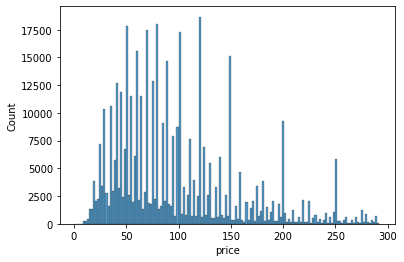

In [12]:
sns.histplot(data=df2, x="price")
plt.show()

### Xử lý missing values

Khi xử lý tập dữ liệu, chúng em để ý thấy các tập hợp:

- (host_response_rate, host_response_time)
- (review_scores_cleanliness,review_scores_value,review_scores_accuracy,reviews_per_month)

In [13]:
df2['host_response_rate'] = df2['host_response_rate'].fillna(0)
df2[['host_response_time','amenities']] = df2[['host_response_time','amenities']].fillna("Not Avaialble")

In [14]:
cols = ['review_scores_cleanliness','review_scores_value','review_scores_accuracy','reviews_per_month']
df2[cols][df2['reviews_per_month'].isnull()]

,review_scores_cleanliness,review_scores_value,review_scores_accuracy,reviews_per_month
12,NaN,NaN,NaN,NaN
24,NaN,NaN,NaN,NaN
26,NaN,NaN,NaN,NaN
31,NaN,NaN,NaN,NaN
34,NaN,NaN,NaN,NaN
...,...,...,...,...
494928,NaN,NaN,NaN,NaN
494933,NaN,NaN,NaN,NaN
494934,NaN,NaN,NaN,NaN
494946,NaN,NaN,NaN,NaN


In [15]:
df2[cols].std()

review_scores_cleanliness    1.039317
review_scores_value          0.903184
review_scores_accuracy       0.852110
reviews_per_month            1.769312
dtype: float64

Những cột này đều có điểm chung là không có các thông số review nên không hợp lý khi ta xử lý các Nan values này một cách quá tùy tiện như thay thế bằng mod, median, mean,... Vì vậy, ta có thể xem như các ngôi nhà ở đây chưa được review trong khi thu nhập dữ liệu và điền các missing value = 0. Trong khi những cột còn lại độ lệch chuẩn không cao, khoảng 1.

In [16]:
mask = df2['reviews_per_month'].isna()
df2.loc[mask,cols] = 0

Có ba trường hợp missing đối với những cột có reviews_per_month:

- Cả 3 cột đều bị Nan
- Hai cột bất kì bị Nan
- Một cột bất kì bị Nan

Trường hợp 1 và 2 ta nên xóa các dòng đấy bởi vì không đủ dữ kiện để điền missing. Đối với trường hợp 3, ta có thể tính điểm trung bình của 2 cột còn lại.

In [17]:
df2[cols][df2['review_scores_cleanliness'].isnull() & df2['review_scores_value'].isnull() & df2['review_scores_accuracy'].isnull()]

,review_scores_cleanliness,review_scores_value,review_scores_accuracy,reviews_per_month
381,NaN,NaN,NaN,0.94
455,NaN,NaN,NaN,0.10
502,NaN,NaN,NaN,0.15
512,NaN,NaN,NaN,0.28
550,NaN,NaN,NaN,0.71
...,...,...,...,...
494172,NaN,NaN,NaN,0.14
494181,NaN,NaN,NaN,0.04
494182,NaN,NaN,NaN,0.03
494525,NaN,NaN,NaN,0.10


In [18]:
df2 = df2.dropna(subset=['review_scores_accuracy','review_scores_value'],how='all')
df2 = df2.dropna(subset=['review_scores_cleanliness','review_scores_value'],how='all')
df2 = df2.dropna(subset=['review_scores_accuracy','review_scores_cleanliness'],how='all')
df2 = df2.reset_index(drop=True)

In [19]:
nan_idx = list(df2[cols][df2['review_scores_accuracy'].isnull()].index)
df2[cols].iloc[nan_idx]

,review_scores_cleanliness,review_scores_value,review_scores_accuracy,reviews_per_month
3012,2.0,2.0,NaN,0.48
3385,10.0,8.0,NaN,1.00
8284,8.0,6.0,NaN,0.03
16523,8.0,8.0,NaN,0.26
29596,10.0,10.0,NaN,0.12
...,...,...,...,...
406711,8.0,10.0,NaN,0.25
415476,6.0,6.0,NaN,0.11
420651,10.0,10.0,NaN,0.03
427764,4.0,6.0,NaN,0.26


In [20]:
df2['review_scores_accuracy'] = df2['review_scores_accuracy'].fillna((df2['review_scores_value'] + df2['review_scores_cleanliness']) / 2)
df2['review_scores_value'] = df2['review_scores_value'].fillna((df2['review_scores_accuracy'] + df2['review_scores_cleanliness']) / 2)
df2['review_scores_cleanliness'] = df2['review_scores_cleanliness'].fillna((df2['review_scores_value'] + df2['review_scores_accuracy']) / 2)

In [21]:
df2[cols].iloc[nan_idx]

,review_scores_cleanliness,review_scores_value,review_scores_accuracy,reviews_per_month
3012,2.0,2.0,2.0,0.48
3385,10.0,8.0,9.0,1.00
8284,8.0,6.0,7.0,0.03
16523,8.0,8.0,8.0,0.26
29596,10.0,10.0,10.0,0.12
...,...,...,...,...
406711,8.0,10.0,9.0,0.25
415476,6.0,6.0,6.0,0.11
420651,10.0,10.0,10.0,0.03
427764,4.0,6.0,5.0,0.26


Đối với cột calculated_host_listings_count, bởi vì đây là cột thể hiện số lượng nhà của một host, ta chỉ cần groupby chúng bằng host_id rồi đếm số lần xuất hiện của chúng để tìm ra kết quả thực.

In [22]:
df2['calculated_host_listings_count'] = df2.groupby('host_id')['host_id'].transform('count')

In [23]:
nan_list = df2.isna().sum().to_numpy()
nan_idx = []
for i in range(len(nan_list)):
  if nan_list[i] > 0:
    tmp = []
    tmp.append(df2.keys()[i])
    tmp.append(df2[df2.keys()[i]].dtypes)
    tmp.append(nan_list[i])
    tmp.append(round(nan_list[i]/df2.shape[0] *100,2))
    nan_idx.append(tmp)
df3 = pd.DataFrame(nan_idx, columns = ["col_name","type","nan_amount","%"])
df3

,col_name,type,nan_amount,%
0,name,object,296,0.07
1,host_name,object,447,0.10
2,city,object,273,0.06
3,country,object,2,0.00


Sau khi xử lý missing value, ta chỉ còn một số cột và những cột này không cần xử lý bởi vì khi đưa vào mô hình ta sẽ drop những cột này.

## Exploratory Data Analysis

Câu hỏi:


Phân tích về 5 thành phố có nhiều khu cho thuê nhất:
1. Theo property_type
2. Theo room_type

In [24]:
city_price = df2[['city']].value_counts().head(6)
city_price

city       
Paris          51950
London         44836
Berlin         19919
Roma           18001
Los Angeles    17624
New York       16896
dtype: int64

In [25]:
city_list = ['Paris','London','Berlin', 'Roma', 'Los Angeles']
df_city = df2[df2['city'].isin(city_list)]
df_city

,id,latitude,longitude,name,host_id,host_name,host_response_time,host_response_rate,city,country,...,minimum_nights,maximum_nights,number_of_reviews,reviews_per_month,review_scores_value,review_scores_cleanliness,review_scores_accuracy,calculated_host_listings_count,amenities,host_url
469,15802051,51.481424,-0.113259,Large double available now.,46296095,Miles,within a few hours,100.0,London,United Kingdom,...,3.0,1125.0,3.0,0.83,10.0,9.0,9.0,2,"Internet,Wireless Internet,Kitchen,Smoking all...",https://www.airbnb.com/users/show/46296095
470,14751869,51.455616,-0.122839,Spacious 4BR home near Brixton and Clapham,11850512,Richard,within an hour,100.0,London,United Kingdom,...,3.0,1125.0,21.0,3.73,10.0,10.0,10.0,1,"TV,Internet,Wireless Internet,Kitchen,Buzzer/w...",https://www.airbnb.com/users/show/11850512
471,8901485,51.501491,-0.111896,quirky room with a view,12594665,Robert,Not Avaialble,0.0,London,United Kingdom,...,1.0,1125.0,0.0,0.00,0.0,0.0,0.0,1,"TV,Internet,Wireless Internet,Kitchen,Buzzer/w...",https://www.airbnb.com/users/show/12594665
472,5832248,51.455858,-0.113217,Lovely 2r flat in the ❤ of Brixton,30273453,Eve,Not Avaialble,0.0,London,United Kingdom,...,3.0,1125.0,2.0,0.11,10.0,10.0,10.0,1,"Internet,Wireless Internet,Kitchen,Heating,Fam...",https://www.airbnb.com/users/show/30273453
473,8049784,51.424140,-0.136928,Lovely bedroom in a cosy house,33670376,Meire,within a day,100.0,London,United Kingdom,...,1.0,1125.0,3.0,0.18,9.0,9.0,9.0,1,"TV,Internet,Wireless Internet,Kitchen,Free par...",https://www.airbnb.com/users/show/33670376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437663,9967282,52.447320,13.617012,Luxusapartment für 1-6 Gäste,943996,Monika,within a few hours,100.0,Berlin,Germany,...,3.0,1125.0,17.0,1.03,9.0,10.0,10.0,6,"TV,Internet,Wireless Internet,Kitchen,Free par...",https://www.airbnb.com/users/show/943996
437664,8699527,52.528116,13.461938,Big bright room in a good location for tavellers,2989041,Nikita,within an hour,100.0,Berlin,Germany,...,4.0,1125.0,6.0,0.54,9.0,9.0,10.0,1,"Internet,Wireless Internet,Kitchen,Smoking all...",https://www.airbnb.com/users/show/2989041
437665,16881873,52.523728,13.474913,Room for rent,91183137,Muhammad,within a day,100.0,Berlin,Germany,...,1.0,1125.0,1.0,0.35,8.0,10.0,10.0,1,"Smoking allowed,translation missing: en.hostin...",https://www.airbnb.com/users/show/91183137
437666,18046299,52.496994,13.497096,Privatzimmer in grünen und ruhigen herzen Berlins,33062083,Jonas,within an hour,100.0,Berlin,Germany,...,1.0,1125.0,2.0,2.00,10.0,10.0,10.0,1,"TV,Internet,Wireless Internet,Kitchen,Free par...",https://www.airbnb.com/users/show/33062083


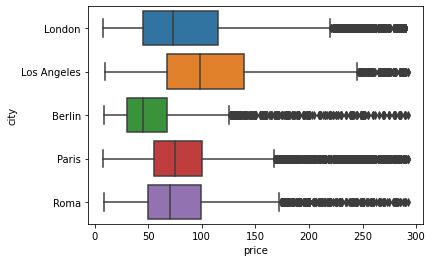

In [26]:
sns.boxplot(data=df_city, y='city', x='price', fliersize=5)
plt.show()

Dựa vào biểu đồ boxplot trên có thể thấy rằng: London và Los Angeles có range về giá cao nhất trong 5 thành phố dẫn tới . Trong khi đó, Berlin có range về giá thấp nhất và cũng có thể thấy Berlin có ít outliner nhất trong 5 thành phố. Dẫn tới việc các quốc gia các range về giá càng cao thì càng nhiều outliner 

In [27]:
property_type_count  = df_city['property_type'].value_counts()
property_type_count = property_type_count[:10,]

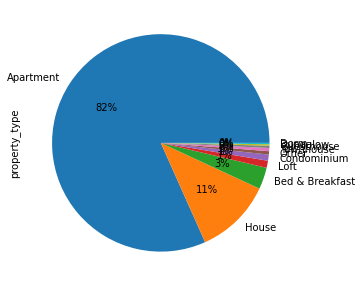

In [28]:
property_type_count.plot.pie(y=property_type_count.values, figsize=(5, 5), autopct='%1.0f%%')
plt.show()

Biểu đồ pie char biểu diễn sự ưa chuộng loại hình thức khu cho thuê
Dễ dàng thấy rằng Apartment chiếm tỉ lệ cao nhất và vượt trội hoàn toàn so với các kiểu còn lại (81%). Theo sau là house 12%, Bed & Breakfast (3%)
Như vậy, Apartmen là hình thức khu cho thuê ưa chuộng nhất bởi vì khách du lịch họ chỉ cần một nơi đủ tốt để ở, ngủ và dành nhiều tiền cho việc tham quan du lịch hơn là chỗ ở. Những khách mà đi với gia đình hay bạn bè họ thường sẽ có thuê nguyên căn nhà (House) để có đủ không gian 

In [29]:
roomtype_group_counts = df_city['room_type'].value_counts().rename('Tần suất')
roomtype_group_percent = df_city.groupby(['room_type'])['number_of_reviews'].sum().transform(lambda x: np.round(x/x.sum(),2)*100).rename('% Lượt thuê phòng')

In [30]:
Q2_df = df_city[['room_type','number_of_reviews']]
Q2_df = pd.concat([roomtype_group_counts, roomtype_group_percent], axis=1)
Q2_df

,Tần suất,% Lượt thuê phòng
Entire home/apt,97980,68.0
Private room,51668,30.0
Shared room,2682,1.0


In [31]:
new_data_df = df_city.copy()

In [32]:
private_room_df = new_data_df[new_data_df['room_type'] == 'Private room']
shared_room_df = new_data_df[new_data_df['room_type'] == 'Shared room']
entire_room_df = new_data_df[new_data_df['room_type'] == 'Entire home/apt']

In [33]:
Q4_df = new_data_df[new_data_df['room_type'].isin(['Shared room','Entire home/apt', 'Private room'])]
Q4_sum = Q4_df.groupby(['city','room_type'])['price'].mean()
Q4_sum

city         room_type      
Berlin       Entire home/apt     73.943986
             Private room        37.079332
             Shared room         31.197026
London       Entire home/apt    121.658018
             Private room        50.236550
             Shared room         37.228261
Los Angeles  Entire home/apt    137.297988
             Private room        76.247322
             Shared room         38.471730
Paris        Entire home/apt     91.915132
             Private room        55.914436
             Shared room         37.503802
Roma         Entire home/apt     95.305605
             Private room        59.746837
             Shared room         30.346667
Name: price, dtype: float64

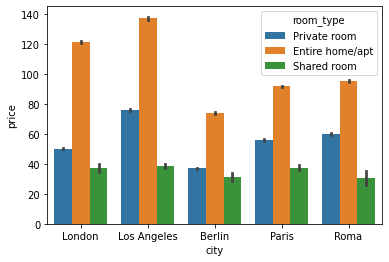

In [34]:
sns.barplot(data=Q4_df, x='city', y='price', hue='room_type')
plt.show()

Như đã đề cập ở biểu đồ boxplot ở trên thì London và Los Angeles là thành phố có giá cho thuê cao nhất trong top 5 thành phố có nhiều khu cho thuê nhất. Bởi thế trong biểu cột ở trên, giá cho thuê theo từng loại phòng cụ thể là private room, entired home/apt và share room của 2 thành phố này cũng là cao nhất. Los Angeles là cao nhất, cao thứ 2 là Anh, cao thứ 3 là Roma, kế cuối là Paris và thấp nhất vẫn là Berlin.

In [35]:
df_host = df2[['host_id','host_name','price','calculated_host_listings_count','bathrooms','bedrooms','beds','accommodates','host_response_rate','extra_people','minimum_nights','maximum_nights','reviews_per_month','review_scores_value','review_scores_cleanliness','review_scores_accuracy','number_of_reviews']].groupby(['host_id','host_name']).mean()\
.sort_values('calculated_host_listings_count',ascending=False).head(100)
df_host

price  calculated_host_listings_count  \
host_id  host_name                                                         
3625030  Angela               124.193777                           707.0   
33889201 Tom                  204.727488                           422.0   
12243051 Sonder               140.860215                           208.0   
         Flatbook             169.921739                           208.0   
43337979 Top Villas Mallorca  157.434555                           191.0   
...                                  ...                             ...   
1408525  Mad4Rent              87.137255                            51.0   
13262085 Maria Belen          150.372549                            51.0   
7572808  Michael              175.600000                            50.0   
22348222 Alicia               152.500000                            50.0   
24194499 Juh                   32.300000                            50.0   

                              bathrooms  bedrooms      beds  accommodates  \
host_id  host_name                                                          
3625030  Angela                2.170438  3.132956  4.613861      6.526167   
33889201 Tom                   1.599526  2.208531  2.637441      4.793839   
12243051 Sonder                1.559140  1.967742  2.311828      4.526882   
         Flatbook              1.230435  1.956522  2.104348      4.739130   
43337979 Top Villas Mallorca   2.282723  3.308901  4.994764      6.895288   
...                                 ...       ...       ...           ...   
1408525  Mad4Rent              1.137255  1.137255  1.392157      3.411765   
13262085 Maria Belen           1.274510  1.431373  2.509804      4.352941   
7572808  Michael               2.410000  3.300000  6.360000      6.720000   
22348222 Alicia                1.000000  0.140000  1.040000      2.060000   
24194499 Juh                   1.020000  1.000000  1.400000      2.840000   

                              host_response_rate  extra_people  \
host_id  host_name                                               
3625030  Angela                        99.000000      2.089109   
33889201 Tom                           98.000000      0.000000   
12243051 Sonder                        99.978495      0.215054   
         Flatbook                      86.095652      6.869565   
43337979 Top Villas Mallorca           96.000000      1.638743   
...                                          ...           ...   
1408525  Mad4Rent                      94.000000      8.921569   
13262085 Maria Belen                   88.000000      2.156863   
7572808  Michael                      100.000000      2.800000   
22348222 Alicia                       100.000000      0.000000   
24194499 Juh                           95.000000     10.000000   

                              minimum_nights  maximum_nights  \
host_id  host_name                                             
3625030  Angela                     6.840170      944.223479   
33889201 Tom                        3.834123     1122.350711   
12243051 Sonder                     2.322581     1125.000000   
         Flatbook                   2.573913     1078.043478   
43337979 Top Villas Mallorca        6.984293     1125.000000   
...                                      ...             ...   
1408525  Mad4Rent                   4.137255      763.725490   
13262085 Maria Belen                2.019608      229.254902   
7572808  Michael                    7.000000     1104.500000   
22348222 Alicia                     7.000000     1125.000000   
24194499 Juh                        1.000000     1125.000000   

                              reviews_per_month  review_scores_value  \
host_id  host_name                                                     
3625030  Angela                        0.070495             3.322489   
33889201 Tom                           0.071919             1.644550   
12243051 Sonder                        1.346237             8.47

Lấy ra top 100 hosts để tiến hành phân tích dữ liệu

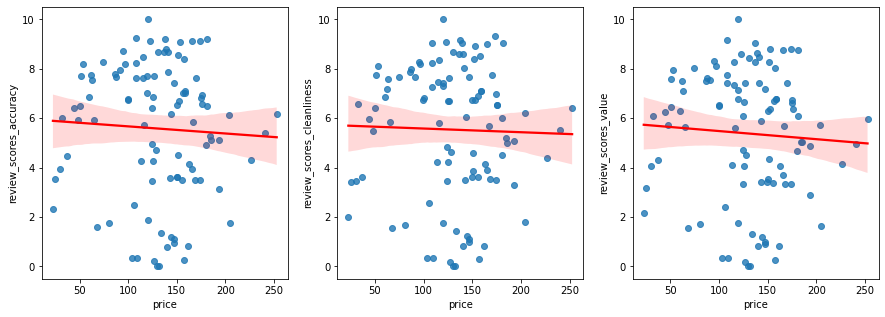

In [36]:
fig, axs = plt.subplots(figsize=(15,5),ncols=3)
sns.regplot(data=df_host, x='price', y='review_scores_accuracy', line_kws={"color": "red"}, ax=axs[0])
sns.regplot(data=df_host, x='price', y='review_scores_cleanliness', line_kws={"color": "red"}, ax=axs[1])
sns.regplot(data=df_host, x='price', y='review_scores_value', line_kws={"color": "red"}, ax=axs[2])
plt.show()

Dựa vào biểu đồ regplot ta thấy các review score không ảnh hưởng đến Giá thuê phòng (price)

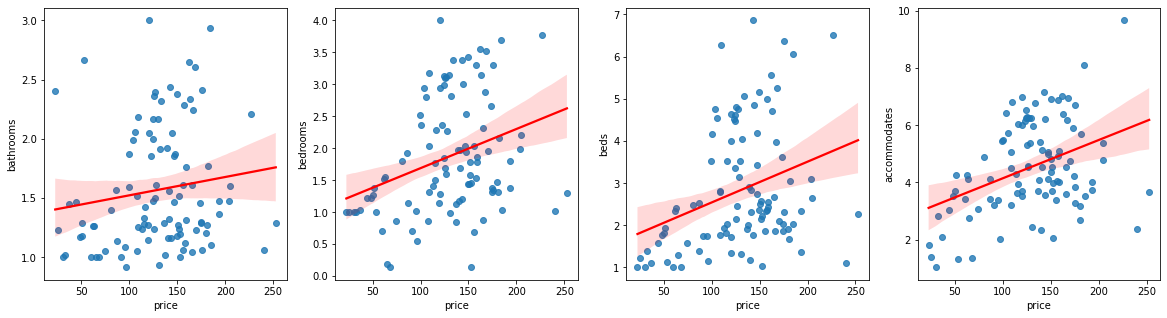

In [37]:
fig, axs = plt.subplots(figsize=(20,5),ncols=4)
sns.regplot(data=df_host, x='price', y='bathrooms', line_kws={"color": "red"}, ax=axs[0])
sns.regplot(data=df_host, x='price', y='bedrooms', line_kws={"color": "red"}, ax=axs[1])
sns.regplot(data=df_host, x='price', y='beds', line_kws={"color": "red"}, ax=axs[2])
sns.regplot(data=df_host, x='price', y='accommodates', line_kws={"color": "red"}, ax=axs[3])
plt.show()

Mặt khác thì các tiện ích/nội thất như bathrooms, bedrooms, beds, accommodates ảnh hưởng khá nhiều đến Giá thuê phòng (price), có thể thấy số lượng tiện ích/nội thất càng nhiều thì giá cũng càng cao

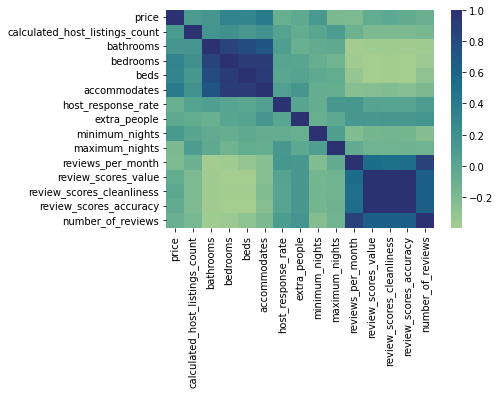

In [38]:
df_host_heatmap = df_host.corr()
sns.heatmap(df_host_heatmap, cmap='crest')
plt.show()

Nhìn vào biểu đồ heatmap, ta có thể chia dữ liệu thành 2 cụm dữ liệu đó là Điểm đánh giá (review_scores_value, review_scores_cleanliness, review_scores_accuracy) và Các tiện ích/nội thất (bathrooms, bedrooms, beds, accommodates). Nhìn hình ta có thể thấy tương quan giữa 2 cụm dữ liệu này với nhau thì chúng không ảnh hưởng đến nhau (có thể màu của các ô là màu nhạt). Mặt khác tương quan giữa từng phần tử trong từng cụm thì chúng có mối liên kết với nhau rất chặt chẽ (màu của các ô là màu đậm)

In [39]:
df2 = df2[df2.room_type != '9']
df_type = df2[['property_type','room_type','price']]
df_heatmap = df_type.pivot_table(values='price',columns='property_type',index='room_type',aggfunc=np.mean )

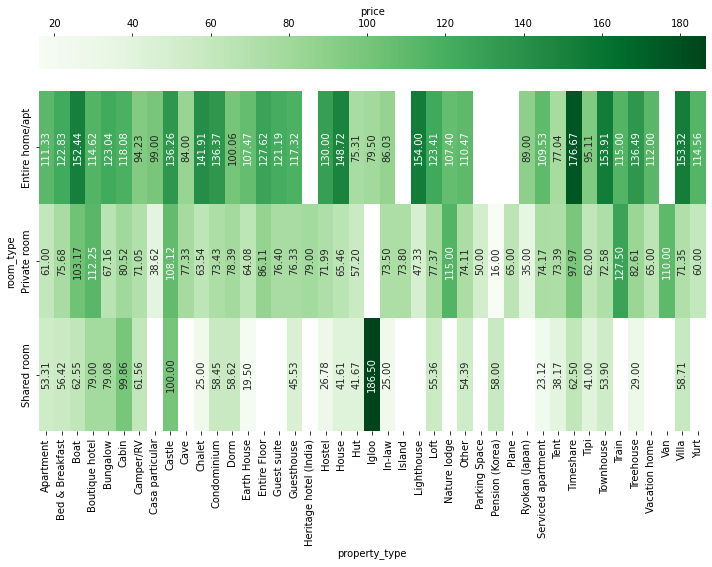

In [40]:
fig, ax = plt.subplots(figsize=(10, 8))
heatmap = sns.heatmap(df_heatmap,annot=True, fmt='.2f',annot_kws={'rotation': 90},cbar=True, ax=ax, cmap='Greens', cbar_kws={'location':'top','label': 'price'})
cbar = heatmap.collections[0].colorbar
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=90, va='center')
plt.tight_layout()
plt.show()

Dựa vào heatmap thể hiện sự tương quan của từng loại phòng (room_type) với từng loại dịch vụ (property_type) thì ta có thể đưa ra được các nhận xét như sau:
- Loại nhà nguyên căn (Entire home/apt) có giá trung bình của các loại dịch vụ cao nhất (màu đậm), sau đó là Private room và cuối cùng là Shared room (màu nhạt dần). 
- Entire home/apt có các điểm dữ liệu nổi bật là Island (985.00), Castle (264.88), Tent (240.84)
- Private room có các điểm dữ liệu nổi bật là Igloo (302.00), Timeshare (155.51), Castle (154.47)
- Shared room có các điểm dữ liệu nổi bật là Chalet (485.50), Boutique hotel (386.33), Igloo (291.00)

## Model

Trước khi thực hiện tạo mô hình học máy, ta cần xử lý các công đoạn quan trọng như khử outlier, loại bỏ các cột không cần thiết, encode các dữ liệu dạng chữ,...

### Ouliers Detection

In [41]:
def outlier_detection(df,x):
    Q1 = x.quantile(q=0.25)
    Q3 = x.quantile(q=0.75)
    IQR = 1.5 * abs(Q1-Q3)

    Q1_boundary = Q1 - IQR
    Q3_boundary = Q3 + IQR
    del_idx = list(df.price[(df.price < Q1_boundary) | (df.price > Q3_boundary)].index)
    return del_idx

# Delete those whose price is 0
df2 = df2[df2.price != 0]
# Remove outliers
del_idx = outlier_detection(df2,df2.price)
df2 = df2.drop(del_idx)

In [42]:
# Drop unnecessary columns
df2 = df2.drop(['id','latitude','longitude','name','host_id','host_name','host_url'],axis=1)

### Encoding Variables

Ta cần encode các cột dạng categorical sang numerical để có thể tạo model cho dữ liệu

Ta sẽ giữ nguyên 100 thành phố tập trung đông các nhà được đăng ký và cho các thành phố còn lại thành **Others**

In [43]:
top_city = 100
need_city = df2['city'].value_counts().head(top_city).index.tolist()

In [44]:
len(need_city) / len(df2['city'].value_counts()) * 100

2.0104543626859672

Ta chọn top 100 thành phố đông nhất bởi vì chỉ với 100 thành phố trên đã chiếm % dữ liệu

In [45]:
df2.loc[~df2['city'].isin(need_city), 'city'] = 'Other'

Spearman's rank correlation là một kiểm tra phi tham số về mức độ tương quan, sức mạnh, hướng liên kết giữa hai biến được đo lường trên một thước đo nhất định. Thước đo ở đây ta sẽ lấy trung bình giá của từng loại dữ liệu. 

In [46]:
numeric_cols = [f for f in df2.columns if df2.dtypes[f] != 'object']
categorical_cols = [f for f in df2.columns if df2.dtypes[f] == 'object']

del_cols = ['city','country','neighbourhood_cleansed','amenities','features']
categorical_cols = [x for x in categorical_cols if (x not in del_cols)]

In [47]:
# Encode categorical columns with spearman's rank correlation
df4 = df2.copy()
def encode(df, feature):
    ordering = pd.DataFrame()
    ordering['val'] = df[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = df[[feature, 'price']].groupby(feature).mean()['price']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    print(feature,ordering[['spmean','ordering']])
    ordering = ordering['ordering'].to_dict()

    for cat, o in ordering.items():
        df.loc[df[feature] == cat, feature+'_E'] = o
    
encoded_cols = []
for q in categorical_cols:
    encode(df4,q)
    encoded_cols.append(q+'_E')

df4['amenities'] = df4['amenities'].transform(lambda x: x.lower().split(","))

host_response_time                        spmean  ordering
val                                    
a few days or more  82.477039         1
Not Avaialble       87.264475         2
within an hour      91.105894         3
within a day        91.114087         4
within a few hours  93.152042         5
property_type                             spmean  ordering
val                                         
Pension (Korea)          37.000000         1
Hostel                   44.223097         2
Casa particular          45.333333         3
Parking Space            50.000000         4
Dorm                     58.991142         5
Ryokan (Japan)           62.000000         6
Tent                     62.811111         7
Hut                      64.461538         8
Plane                    65.000000         9
Island                   73.800000        10
Bed & Breakfast          75.973576        11
Heritage hotel (India)   79.000000        12
Lighthouse               80.400000        13
Tipi        

Đối với các cột như city, country và amenities là kiểu dữ liệu dạng phân loại, chúng cần được thực hiện encoding với get_dummies.

In [48]:
dummy_city = pd.get_dummies(df4.city, prefix="city")
dummy_country = pd.get_dummies(df4.country, prefix="country")
mlb = MultiLabelBinarizer()
dummy_amenities = pd.DataFrame(mlb.fit_transform(df4['amenities']),columns=mlb.classes_, index=df4.index)

In [49]:
dummy_city

,city_Alcúdia,city_Amsterdam,city_Antwerpen,city_Athens,city_Athina,city_Austin,city_Barcelona,city_Berlin,city_Beverly Hills,city_Bondi,...,city_Toronto,city_Vancouver,city_Venezia,city_Venice,city_Vienna,city_Ville de Québec,city_Washington,city_West Hollywood,city_Wien,city_Αθήνα
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437663,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
437664,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
437665,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
437666,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
dummy_amenities

,24-hour check-in,accessible-height bed,accessible-height toilet,air conditioning,baby bath,baby monitor,babysitter recommendations,bathtub,bbq grill,beach essentials,...,washer,washer / dryer,waterfront,wheelchair accessible,wide clearance to bed,wide clearance to shower and toilet,wide doorway,wide hallway clearance,window guards,wireless internet
0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437663,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
437664,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
437665,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
437666,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


Cuối cùng, ta gộp các cột cần thiết để huấn luyện mô hình lại để sang công đoạn tiếp theo.

In [51]:
df5 = pd.concat([df4[encoded_cols + numeric_cols], dummy_city, dummy_country,dummy_amenities], axis=1)
df5 = df5.drop(['translation missing: en.hosting_amenity_49','translation missing: en.hosting_amenity_50'],axis=1)

In [52]:
df5

,host_response_time_E,property_type_E,room_type_E,bed_type_E,cancellation_policy_E,host_response_rate,accommodates,bathrooms,bedrooms,beds,...,washer,washer / dryer,waterfront,wheelchair accessible,wide clearance to bed,wide clearance to shower and toilet,wide doorway,wide hallway clearance,window guards,wireless internet
0,5.0,23.0,3.0,5.0,8.0,100.0,4.0,1.0,2.0,2.0,...,1,0,0,0,0,0,0,0,0,1
1,2.0,23.0,3.0,5.0,3.0,0.0,4.0,1.0,2.0,2.0,...,1,0,0,0,0,0,0,0,0,1
2,4.0,23.0,3.0,5.0,3.0,100.0,4.0,1.0,2.0,4.0,...,1,0,0,0,0,0,0,0,0,1
3,4.0,23.0,3.0,5.0,6.0,100.0,2.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
4,4.0,23.0,3.0,5.0,8.0,100.0,2.0,1.0,1.0,1.0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437663,5.0,23.0,3.0,5.0,8.0,100.0,6.0,1.0,3.0,6.0,...,1,0,0,0,0,0,0,0,0,1
437664,3.0,23.0,2.0,5.0,6.0,100.0,2.0,1.5,1.0,2.0,...,1,0,0,0,0,0,0,0,0,1
437665,4.0,23.0,2.0,5.0,3.0,100.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
437666,3.0,23.0,2.0,5.0,3.0,100.0,1.0,1.0,1.0,1.0,...,1,0,0,0,0,0,0,0,0,1


In [ ]:
from sklearn.decomposition import PCA
def PCA_process(X):
  pca_impl = PCA(n_components = 2)
  X_pca = pca_impl.fit_transform(X)
  return X_pca

In [ ]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt

### Prepare data

Đầu tiên, ta cần đảm bảo dữ liệu sẵn sàng như tách X,y và tiến hành scale chúng. Sau đó phân chia tập train, test, validation theo tỷ lệ 8:2

In [ ]:
X = df5.loc[:, df5.columns != 'price']
y = df5[['price']]

X_scaled = X
y_scaled = y

TargetVarScaler=StandardScaler()
TargetVarScalerFit=TargetVarScaler.fit(y_scaled)
y_scaled=TargetVarScalerFit.transform(y)

X_array = np.array(df5.values).astype("float32")
y_array = np.array(y_scaled).astype("float32")

X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.2, random_state=2032)
y_test_orig = TargetVarScalerFit.inverse_transform(y_test)

Một số metrics như MAPE và RMSE có thể sử dụng để có thể đánh giá mô hình.

- Mean Absolute Percentage Error (MAPE) : Sai số phần trăm tuyệt đối trung bình, còn được gọi là độ lệch phần trăm tuyệt đối trung bình, là thước đo độ chính xác dự đoán của một phương pháp dự báo trong thống kê. Bởi vì giá trị được tính là phần trăm nên khi áp dụng thực tế, ta có thể lấy 100 - MAPE để ra được độ chính xác tuyệt đối của mô hình.

- Root Mean Square Error (RMSE): là căn bậc hai của mức trung bình của các sai số bình phương. RMSE là độ lệch chuẩn của các phần dư (sai số dự đoán). Phần dư là thước đo khoảng cách từ các điểm dữ liệu đường hồi quy; RMSE là thước đo mức độ dàn trải của những phần dư này, nói cách khác, nó cho bạn biết mức độ tập trung của dữ liệu xung quanh đường phù hợp nhất. RMSE càng nhỏ thì mô hình càng tốt.

- Learning Curve: Đường cong học tập vẽ biểu đồ giá trị tối ưu của hàm mất mát của mô hình cho một tập huấn luyện dựa trên hàm mất mát này được đánh giá trên tập dữ liệu xác nhận với các tham số giống như được tạo ra của hàm tối ưu.

In [ ]:
def Accuracy_Score(orig, pred):
    MAPE = np.mean(100 * (np.abs(orig - pred) / orig))
    return(100-MAPE)

In [ ]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
def cv_rmse(model1, X,y):
    rmse = np.sqrt(-cross_val_score(model1, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [ ]:
def plot_curves(X_train,X_test,y_train,y_test,clf,title):
  plot_learning_curves(X_train=X_train,
                      y_train=y_train,
                      X_test=X_test,
                      y_test=y_test,
                      clf=clf,
                      scoring='mean_squared_error',
                      print_model=False)
  
  plt.title(title)
  plt.show()

Ngoài ra, ta cũng cần chuẩn bị một hàm PCA cho việc giảm chiều dữ liệu

In [ ]:
from sklearn.decomposition import PCA
def PCA_process(X):
  pca_impl = PCA(n_components = 2)
  X_pca = pca_impl.fit_transform(X)
  return X_pca

### K-nearest Neighbors Regression

**KNN (K-Nearest Neighbors)** là một trong những thuật toán học có giám sát đơn giản nhất được sử dụng nhiều trong khai phá dữ liệu và học máy. Ý tưởng của thuật toán này là nó không học một điều gì từ tập dữ liệu học (nên KNN được xếp vào loại **lazy learning**), mọi tính toán được thực hiện khi nó cần dự đoán nhãn của dữ liệu mới. Lớp(nhãn) của một đối tượng dữ liệu mới có thể dự đoán từ các lớp(nhãn) của k hàng xóm gần nó nhất.

Giả sử ta có D là tập các dữ liệu đã được phân loại thành 2 nhãn (+) và (-) và một số điểm dữ liệu mới chưa biết nhãn. Vậy làm cách nào để chúng ta có thể xác định được nhãn của A là (+) hay (-)?

KNN sẽ thực hiện một phép tính toán học để đo khoảng cách giữa dữ liệu mới với tất cả các điểm trong tập dữ liệu học để thực hiện phân lớp. Phép tính khoảng cách giữa 2 điểm có thể là **Euclidian, Manhattan, trọng số, Minkowski, …**

Khi KNN thực hiện dự đoán hồi quy với một điểm dữ liệu mới, chúng sẽ lấy **k** điểm dữ liệu có đặc trưng giống với điểm dữ liệu mới này dựa vào khoảng cách đã tính ở trên rồi trả về kết quả trung bình của chúng. Tuy nhiên KNN khá nhạy cảm và vulnerable với dữ liệu đa chiều nên ta cần thực hiện PCA trước khi áp dụng thuật toán này.

In [ ]:
X_pca = PCA_process(X_array)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_array, test_size=0.2, random_state=2032)

Ta cần có ba list là rmse_val, accuracy_score và result_val để lưu trữ RMSE, Accuracy và kết quả để có thể lấy được kết quả dự đoán sau khi tìm ra k tốt nhất.

In [ ]:
rmse_val = [] #to store rmse values for different k
accuracy_score = []
result_val = []
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train_pca, y_train_pca)  #fit the model
    pred=model.predict(X_test_pca) #make prediction on test set
    error = sqrt(mean_squared_error(y_test_pca,pred)) #calculate rmse
    acc_score = Accuracy_Score(y_test_pca, pred) #calculate accuracy
    rmse_val.append(error) #store rmse values
    accuracy_score.append(acc_score)
    result_val.append(pred)
    #print('RMSE value for k= ' , K , 'is:', error)

In [ ]:
minpos = rmse_val.index(min(rmse_val))
print("K = ",minpos)

K =  9


Với k trong khoảng [1,20], ta tìm được k = 9 là k optimal bởi vì đây là k có độ lỗi RMSE thấp nhất.

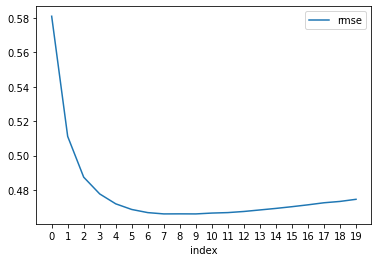

In [ ]:
#elbow curve
curve = pd.DataFrame(rmse_val,columns=['rmse']) 
curve.reset_index().plot(x='index', y='rmse')
plt.xticks(range(0,20))
plt.show()

In [ ]:
minpos = rmse_val.index(min(rmse_val))
print("Accuracy of the Linear model is:", accuracy_score[minpos])
print("RMSE of the Linear model is:", rmse_val[minpos])

Accuracy of the Linear model is: 93.40405893325806
RMSE of the Linear model is: 0.46605191980757826


In [ ]:
# Extract result
pred_org = TargetVarScalerFit.inverse_transform(result_val[minpos])

In [ ]:
# Create dataframe for representing results
combine_pred = np.append(y_test_orig , pred_org,axis=1)
df_knn_pred = pd.DataFrame(combine_pred,columns=['True result','Predicted result'])

In [ ]:
df_knn_pred.head(10)

,True result,Predicted result
0,46.999996,47.400002
1,96.000000,103.500000
2,149.000000,110.000000
3,80.000000,99.500000
4,80.000000,77.599998
5,95.000000,96.400002
6,100.000000,102.400002
7,89.000000,82.500000
8,45.000000,66.900002
9,80.000000,80.500000


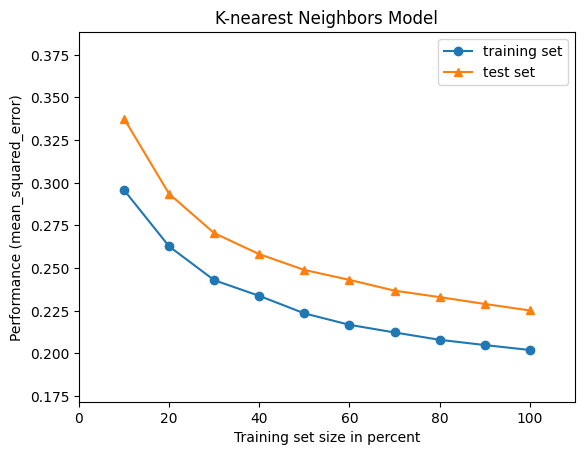

In [ ]:
plot_curves(X_train_pca,X_test_pca,y_train_pca,y_test_pca,model,"K-nearest Neighbors Model")

#### Nhận xét

- Mô hình hồi quy KNN biểu hiện khá tốt với tập dữ liệu trên với độ chính xác tính theo MAPE là ~90% và độ lỗi RMSE chỉ có ~0.5.
- Ta có thể thấy Learning Curve của mô hình KNN bị một chút overfit khi mô hình trên biểu hiện tập train tốt hơn tập test. 
- Tuy nhiên, chúng vẫn có điểm chung là độ lỗi khi tập dữ liệu tăng lên đều có dấu hiệu giảm dần.

### Linear Regression

**Hồi quy tuyến tính(Linear Regression)** là một phương pháp thống kê để hồi quy dữ liệu với biến phụ thuộc có giá trị liên tục trong khi các biến độc lập có thể có một trong hai giá trị liên tục hoặc là giá trị phân loại. Nói cách khác Hồi quy tuyến tính là một phương pháp để dự đoán biến phụ thuộc (Y) dựa trên giá trị của biến độc lập (X). Nó có thể được sử dụng cho các trường hợp chúng ta muốn dự đoán một số lượng liên tục. Ví dụ, dự đoán giao thông ở một cửa hàng bán lẻ, dự đoán thời gian người dùng dừng lại một trang nào đó hoặc số trang đã truy cập vào một website nào đó v.v...

In [ ]:
reg = LinearRegression().fit(X_train,y_train)
linear_predictions = reg.predict(X_test)

linear_predictions_orig = TargetVarScalerFit.inverse_transform(linear_predictions)

In [ ]:
print("Accuracy of the Linear model is:", str(Accuracy_Score(y_test_orig, linear_predictions_orig)))
print("RMSE of the Linear model is:", cv_rmse(reg,X_array,y_array).mean())

Accuracy of the Linear model is: 99.92962788045406
RMSE of the Linear model is: 0.0010536097709691332


In [ ]:
combine_pred = np.append(y_test_orig , linear_predictions_orig,axis=1)
df_linear_pred = pd.DataFrame(combine_pred,columns=['True result','Predicted result'])

In [ ]:
df_linear_pred.head(10)

,True result,Predicted result
0,46.999996,46.975368
1,96.000000,95.935600
2,149.000000,148.962708
3,80.000000,80.028412
4,80.000000,79.960808
5,95.000000,95.083855
6,100.000000,100.014450
7,89.000000,88.982765
8,45.000000,44.968033
9,80.000000,79.944450


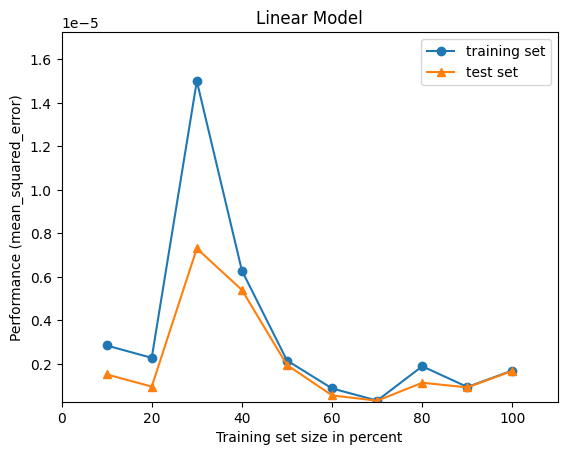

In [ ]:
plot_curves(X_train,X_test,y_train,y_test,reg,"Linear Model")

#### Nhận xét
- Mô hình hồi quy Linear Regression biểu hiện rất tốt với tập dữ liệu trên với độ chính xác tính theo MAPE là ~99% và độ lỗi RMSE chỉ có ~0.0015.
- Ta có thể thấy Learning Curve của mô hình Linear Regression từ 60% size trở lên đều duy trì ở mức rất thấp mặc dù có tăng một chút ở 90-100%.
- Mặc dù sở hữu độ chính xác cao và độ lỗi thấp, mô hình không hề bị Overfitting. Bởi vì Learning Curve của tập test luôn luôn có độ lỗi thấp hơn tức là biểu hiện tốt hơn tập train.

### ANN Deep Learning

Artificial Neural Network (ANN) gồm 3 thành phần chính: Input layer và output layer chỉ gồm 1 layer , hidden layer có thể có 1 hay nhiều layer tùy vào bài toán cụ thể. ANN hoạt động theo hướng mô tả lại cách hoạt động của hệ thần kinh với các neuron được kết nối với nhau. Trong ANN, trừ input layer thì tất cả các node thuộc các layer khác đều full-connected với các node thuộc layer trước nó. Mỗi node thuộc hidden layer nhận vào ma trận đầu vào từ layer trước và kết hợp với trọng số để ra được kết quả. ANN còn được gọi là Feed-Forward Neural network.

Lý do ta chọn ANN là bởi vì ANN rất chắc chắn trong việc học những function phi tuyến tính(non-linear). Hàm activation của ANN cũng đóng vai trò quan trọng khi chúng có các weights cho từng các input phi tuyến tính vào trong mạng và trả về một kết quả duy nhất. Nhờ vào đó mà các network có thể học bất kì mối quan hệ phức tạp nào giữa input và output.

In [ ]:
ANN = Sequential()                
ANN.add(Dense(units=10, input_dim=X_train.shape[1], 
                kernel_initializer='normal', activation='relu'))
ANN.add(Dense(1, kernel_initializer='normal'))
ANN.compile(loss='mean_squared_error', optimizer={'batch_size': 30, 'epochs': 20, 'optimizer_trial': 'rmsprop'}['optimizer_trial'])
ANN.fit(X_train, y_train,batch_size = int({'batch_size': 30, 'epochs': 20, 'optimizer_trial': 'rmsprop'}['batch_size']),
        epochs = int({'batch_size': 30, 'epochs': 20, 'optimizer_trial': 'rmsprop'}['epochs']), verbose=0)


ANN_predictions = ANN.predict(X_test)

ANN_predictions_org = TargetVarScalerFit.inverse_transform(ANN_predictions)

In [ ]:
print("Accuracy for the ANN model is:", str(Accuracy_Score(y_test_orig, ANN_predictions_org)))

Accuracy for the ANN model is: 95.0540542602539


In [ ]:
combine_pred = np.append(y_test_orig , ANN_predictions_org,axis=1)
df_ANN_pred = pd.DataFrame(combine_pred,columns=['True result','Predicted result'])

In [ ]:
df_ANN_pred.head(10)

,True result,Predicted result
0,46.999996,45.466518
1,96.000000,93.581223
2,149.000000,143.816635
3,80.000000,78.606468
4,80.000000,77.526276
5,95.000000,90.223640
6,100.000000,98.476418
7,89.000000,86.981071
8,45.000000,45.066883
9,80.000000,78.092896


In [ ]:
ANN1 = Sequential()                
ANN1.add(Dense(units=10, input_dim=X_train.shape[1], 
                kernel_initializer='normal', activation='relu'))
ANN1.add(Dense(1, kernel_initializer='normal'))
ANN1.compile(loss='mean_squared_error', optimizer={'batch_size': 30, 'epochs': 20, 'optimizer_trial': 'rmsprop'}['optimizer_trial'])

10942/10942 [==============================] - 8s 704us/step - loss: 33360334.0000


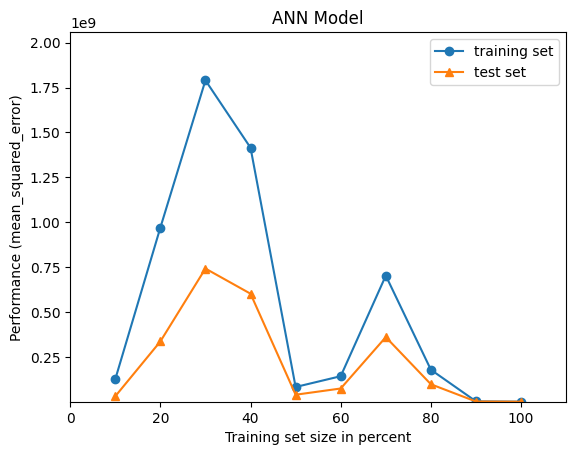

In [ ]:
plot_curves(X_train,X_test,y_train,y_test,ANN1,"ANN Model")

#### Nhận xét:
- Mô hình học sâu ANN biểu hiện rất tốt với tập dữ liệu trên với độ chính xác tính theo MAPE là ~95%.
- Giống với Linear Regression, ANN có độ chính xác cao và không hề bị Overfitting. 
- Learning Curve của ANN có biểu hiện khá giống với Linear Regression khi độ lỗi MSE của tập test luôn thấp hơn tập train.
- Khá thú vị rằng từ 90% trở đi, độ lỗi của chúng gần như cận 0 chứng tỏ mô hình Deep Learning của ta khá tốt.

## Reference
- https://bnbfacts.com/how-airbnb-category-ratings-affect-overall-rating/
- https://kabir-isak.medium.com/airbnb-seattle-data-analysis-2e01f2559614
- https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient
- http://rasbt.github.io/mlxtend/user_guide/plotting/plot_learning_curves/
- https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/
- https://viblo.asia/p/linear-regression-hoi-quy-tuyen-tinh-trong-machine-learning-4P856akRlY3
- https://viblo.asia/p/tong-quan-ve-artificial-neural-network-1VgZvwYrlAw
- https://en.wikipedia.org/wiki/Artificial_neural_network
- https://seaborn.pydata.org/generated/seaborn.regplot.html
- https://stackoverflow.com/questions/63892337/how-to-rotate-seaborn-heatmap-in-python